In [1]:
import numpy as np
import jax.numpy as jnp
import circuitmap as cm

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 12

## simulated data
For each realization of a photocurrent waveform (one line in the plot above) we have many observations (corresponding to different pixels in the grid).

In [2]:
from circuitmap import NeuralDemixer
pc_subtractr = NeuralDemixer(path='../../circuit_mapping/scripts/lightning_logs/gabby-tereshkova-9609/epoch=999-step=1406999.ckpt')
data = np.load('datasample.npz')
test_expts = data['test_expts']
train_expts = data['train_expts']

In [3]:
def viz_network_performance_synthetic(network, expts, num_expts=5, num_traces_per_expt=200, figsize=(5,8), dpi=300):
    fig, axs = plt.subplots(nrows=num_expts, ncols=3, figsize=figsize, dpi=dpi,
        facecolor='white', sharex=True)
    inputs, targets = expts
    for i in range(num_expts):
        inputs, targets = (expts[0][i], expts[1][i])
        out = network(np.array(inputs, dtype=np.float64))
        idxs = np.random.randint(0, inputs.shape[0], size=num_traces_per_expt)

        ymin = np.min(inputs[idxs])
        ymax = np.max(inputs[idxs])

        axs[i,0].plot(inputs[idxs].T)
        axs[i,0].set_ylim(ymin, ymax)

        axs[i,1].plot(targets[idxs].T)
        axs[i,1].set_ylim(ymin, ymax)

        axs[i,2].plot(out[idxs].T)
        axs[i,2].set_ylim(ymin, ymax)

    axs[0,0].set_title('inputs')
    axs[0,1].set_title('targets')
    axs[0,2].set_title('ests')
    return fig

def viz_network_performance_real(network, expts, num_input_traces=100, num_plot_traces=10, figsize=(5,8), dpi=300):
    num_expts = len(expts)
    fig, axs = plt.subplots(nrows=num_expts, ncols=3, figsize=figsize, dpi=dpi, facecolor='white', sharex=True)
    for i in range(num_expts):
        inputs = expts[i]
        input_idxs = np.random.randint(0, inputs.shape[0], size=num_input_traces)
        inputs = inputs[input_idxs]
        out = network(np.array(inputs, dtype=np.float64),)

        plot_idxs = np.random.randint(0, out.shape[0], size=num_plot_traces)

        ymin = np.min(inputs[plot_idxs])
        ymax = np.max(inputs[plot_idxs])

        
        axs[i,0].plot(inputs[plot_idxs].T)
        axs[i,0].set_ylim(ymin, ymax)
        
        axs[i,1].plot(out[plot_idxs].T)
        axs[i,1].set_ylim(ymin, ymax)

        axs[i,2].plot((inputs - out)[plot_idxs].T)
        axs[i,2].set_ylim(ymin, ymax)

    axs[0,0].set_title('inputs')
    axs[0,1].set_title('ests')
    axs[0,2].set_title('subtracted')
    return fig


Demixing PSC traces... complete (elapsed time 0.30s, device=cpu).
Demixing PSC traces... complete (elapsed time 0.26s, device=cpu).
Demixing PSC traces... complete (elapsed time 0.26s, device=cpu).
Demixing PSC traces... complete (elapsed time 0.28s, device=cpu).
Demixing PSC traces... complete (elapsed time 0.25s, device=cpu).


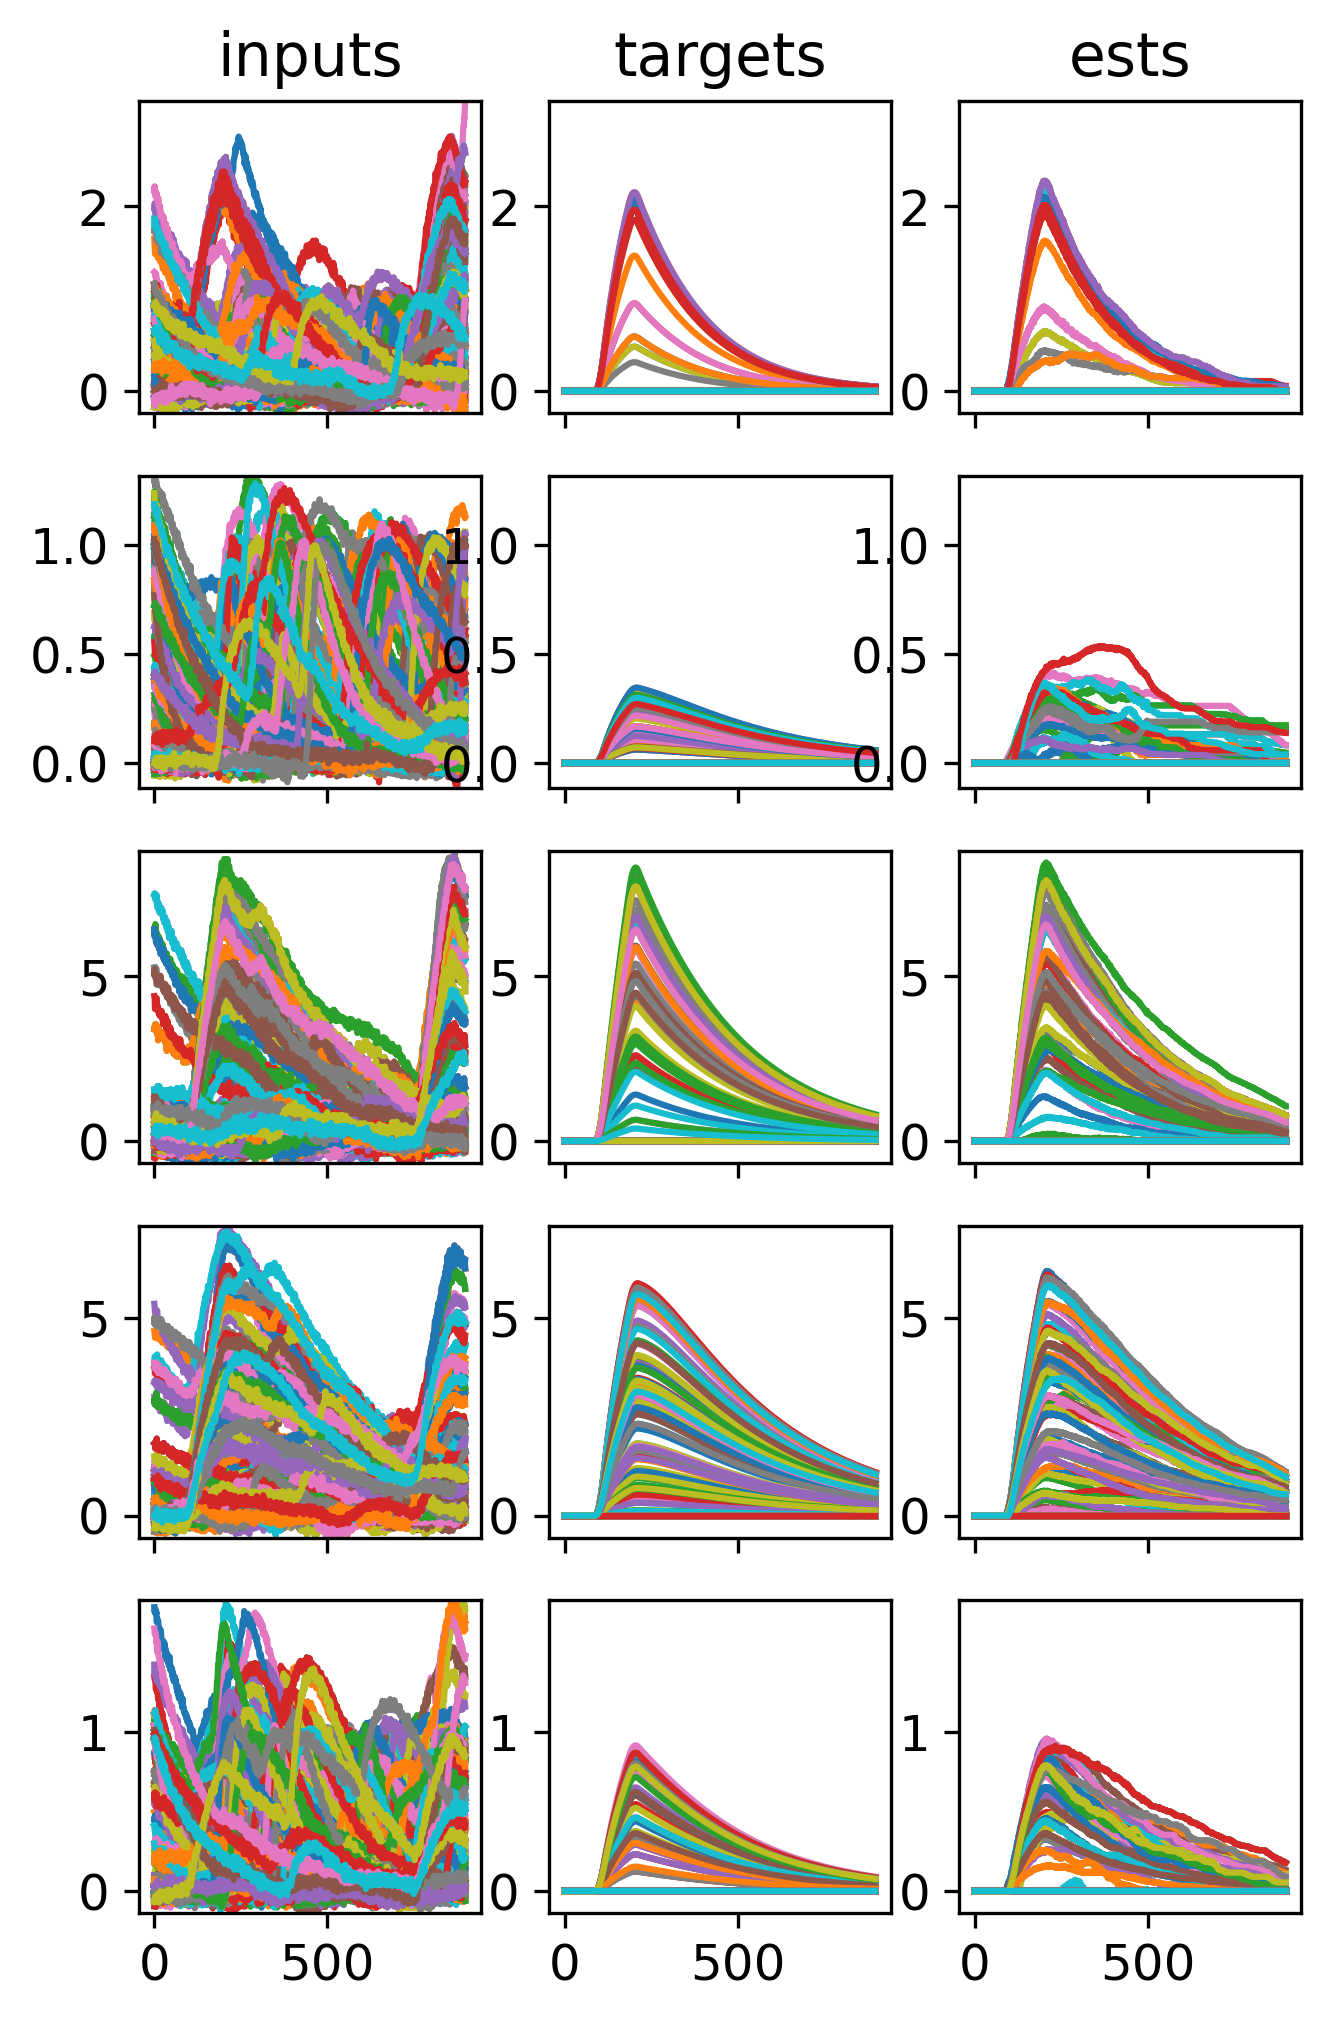

In [4]:
fig = viz_network_performance_synthetic(pc_subtractr, train_expts)

# Real data


In [33]:
import glob
data_path = '../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/'
files = glob.glob(data_path + '*.mat')
print(files)

['../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/test_out.mat', '../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/220822_SSTtDT_hSynDOchrm2fGc8_IC_082222_InVivo_Cell1_A_planes_cmReformat.mat', '../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/220822_SSTtDT_hSynDOchrm2fGc8_IC_082222_InVivo_Cell1_A_grid_cmReformat.mat', '../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/220814_SSTtDT_hSynDOchrm2fGc8_IC_081422_InVivo_Cell2_A_grid_cmReformat.mat', '../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/220822_SSTtDT_hSynDOchrm2fGc8_IC_082222_InVivo_Cell2_A_planes_cmReformat.mat', '../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/220725_SSTtDT_hSynDOchrm2fGc8_IC_072522_InVivo_Cell2_A_grid_cmFormat.mat', '../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/220814_SSTtDT_hSynDOchrm2fGc8_IC_081422_InVivo_Cell1_A_grid_cmReformat.mat', '../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/220822_SSTtDT_hSynDOchrm2fGc8_IC_082222_InVivo_Cell2_A_grid_cmReformat.mat', '..

In [46]:
import h5py
import sys
sys.path.append('../')
import subtract_utils

file_idx = 2
dataset_path = files[file_idx]
print(dataset_path)

../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/220822_SSTtDT_hSynDOchrm2fGc8_IC_082222_InVivo_Cell1_A_grid_cmReformat.mat


In [47]:
with h5py.File(dataset_path) as f:
    pscs = np.array(f['pscs']).T
    stim_mat = np.array(f['stimulus_matrix']).T
    targets = np.array(f['targets']).T
    powers = np.max(stim_mat, axis=0)

# get rid of any trials where we didn't actually stim
good_idxs = (powers > 0)
pscs = pscs[good_idxs,:]
stim_mat = stim_mat[:,good_idxs]
powers = powers[good_idxs]

demixer_checkpoint = '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt'
pc_subtractr = NeuralDemixer(path='./grid_artifacts/heavy-heyrovsky-6276-exp0/scripts/lightning_logs/version_0/checkpoints/epoch=512-step=1443068.ckpt')
results = subtract_utils.run_network_subtraction_pipeline(pscs, powers, targets, stim_mat,
    demixer_checkpoint, pc_subtractr,
    )

# results_old_demixer = subtract_utils.run_subtraction_pipeline(pscs, powers, targets, stim_mat,
#     '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt',
#     separate_by_power=False, rank=1, no_op=True)

Demixing PSC traces... complete (elapsed time 57.73s, device=cpu).


In [48]:
results['raw_map'].shape

(3, 26, 26, 5)

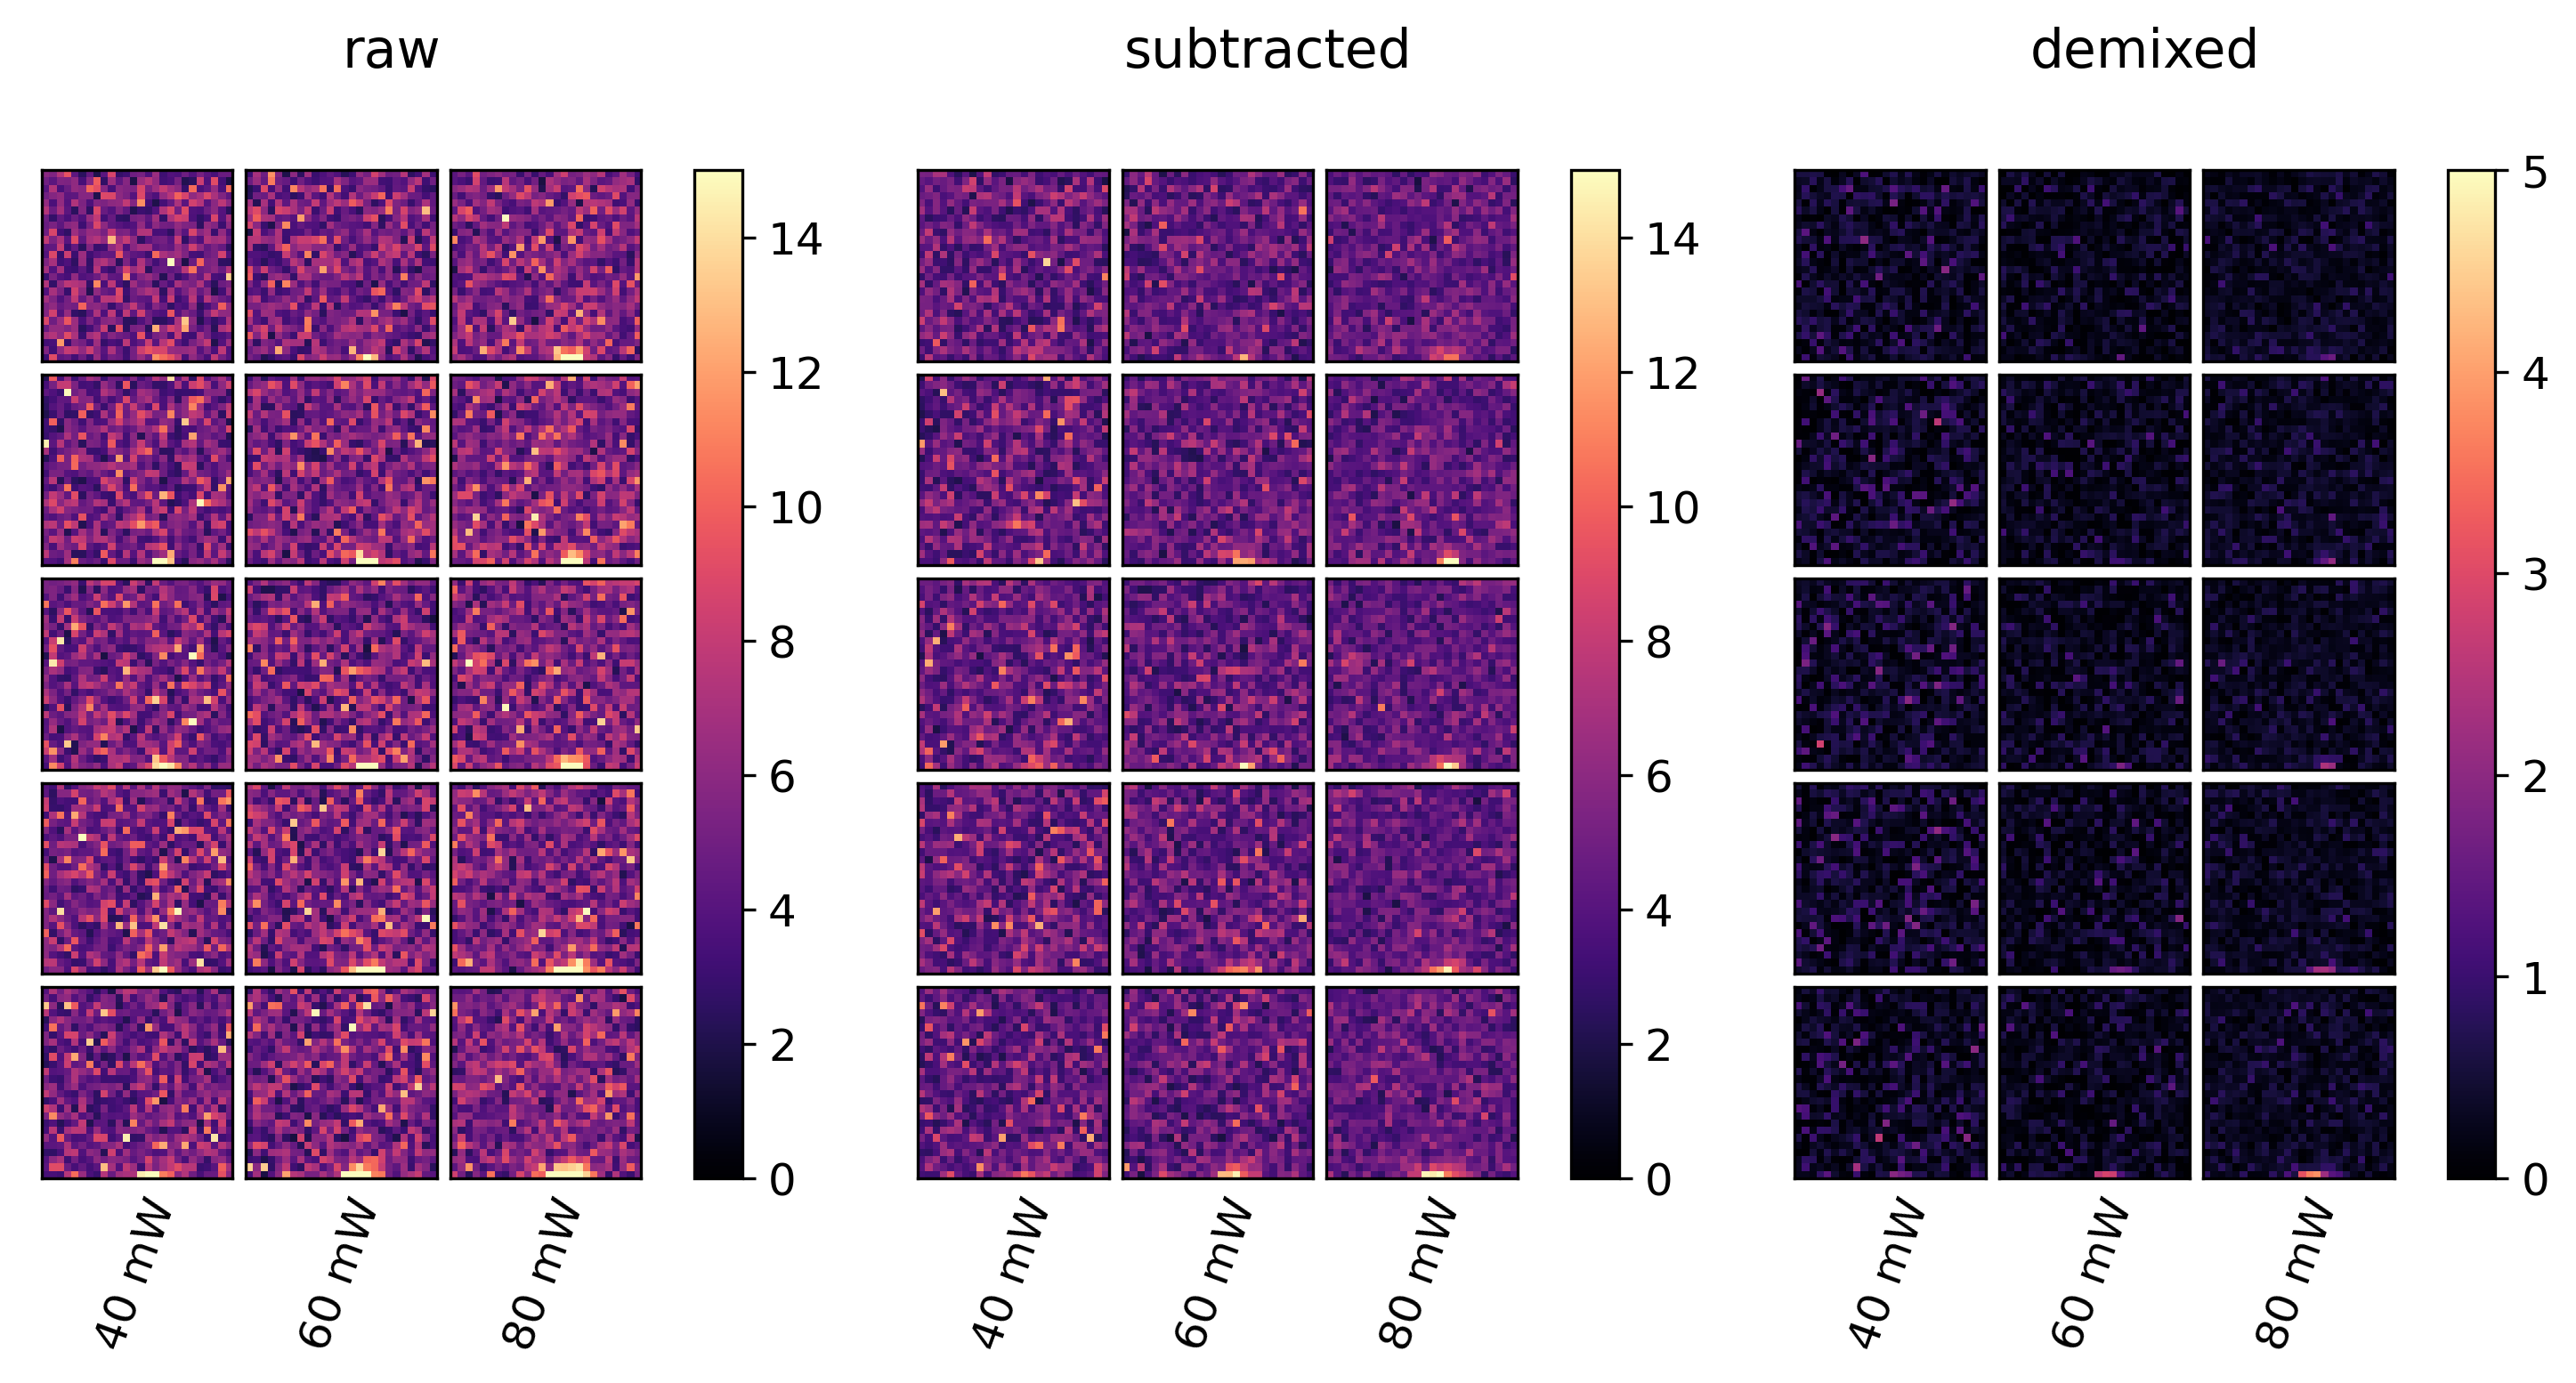

In [49]:
import grid_utils as util

fig2 = plt.figure(figsize=(4 * 3, 5), dpi=300, facecolor='white')

num_planes = results['raw_map'].shape[-1]
util.plot_multi_means(fig2,
    [
        results['raw_map'],
        results['subtracted_map'],
        results['demixed_map'],
    ], 
    np.arange(num_planes),
    map_names=['raw', 'subtracted', 'demixed'],
    cmaps=['magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    # map_names=['raw', 'subtr', 'demix'],
    vranges=[(0,15), (0,15), (0,5)],
    powers=np.unique(powers),
    show_powers=(True, True, True)
)

(<Figure size 3000x5400 with 48 Axes>,
 array([[<AxesSubplot:title={'center':'raw'}>,
         <AxesSubplot:title={'center':'est'}>,
         <AxesSubplot:title={'center':'subtracted'}>,
         <AxesSubplot:title={'center':'demixed'}>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot

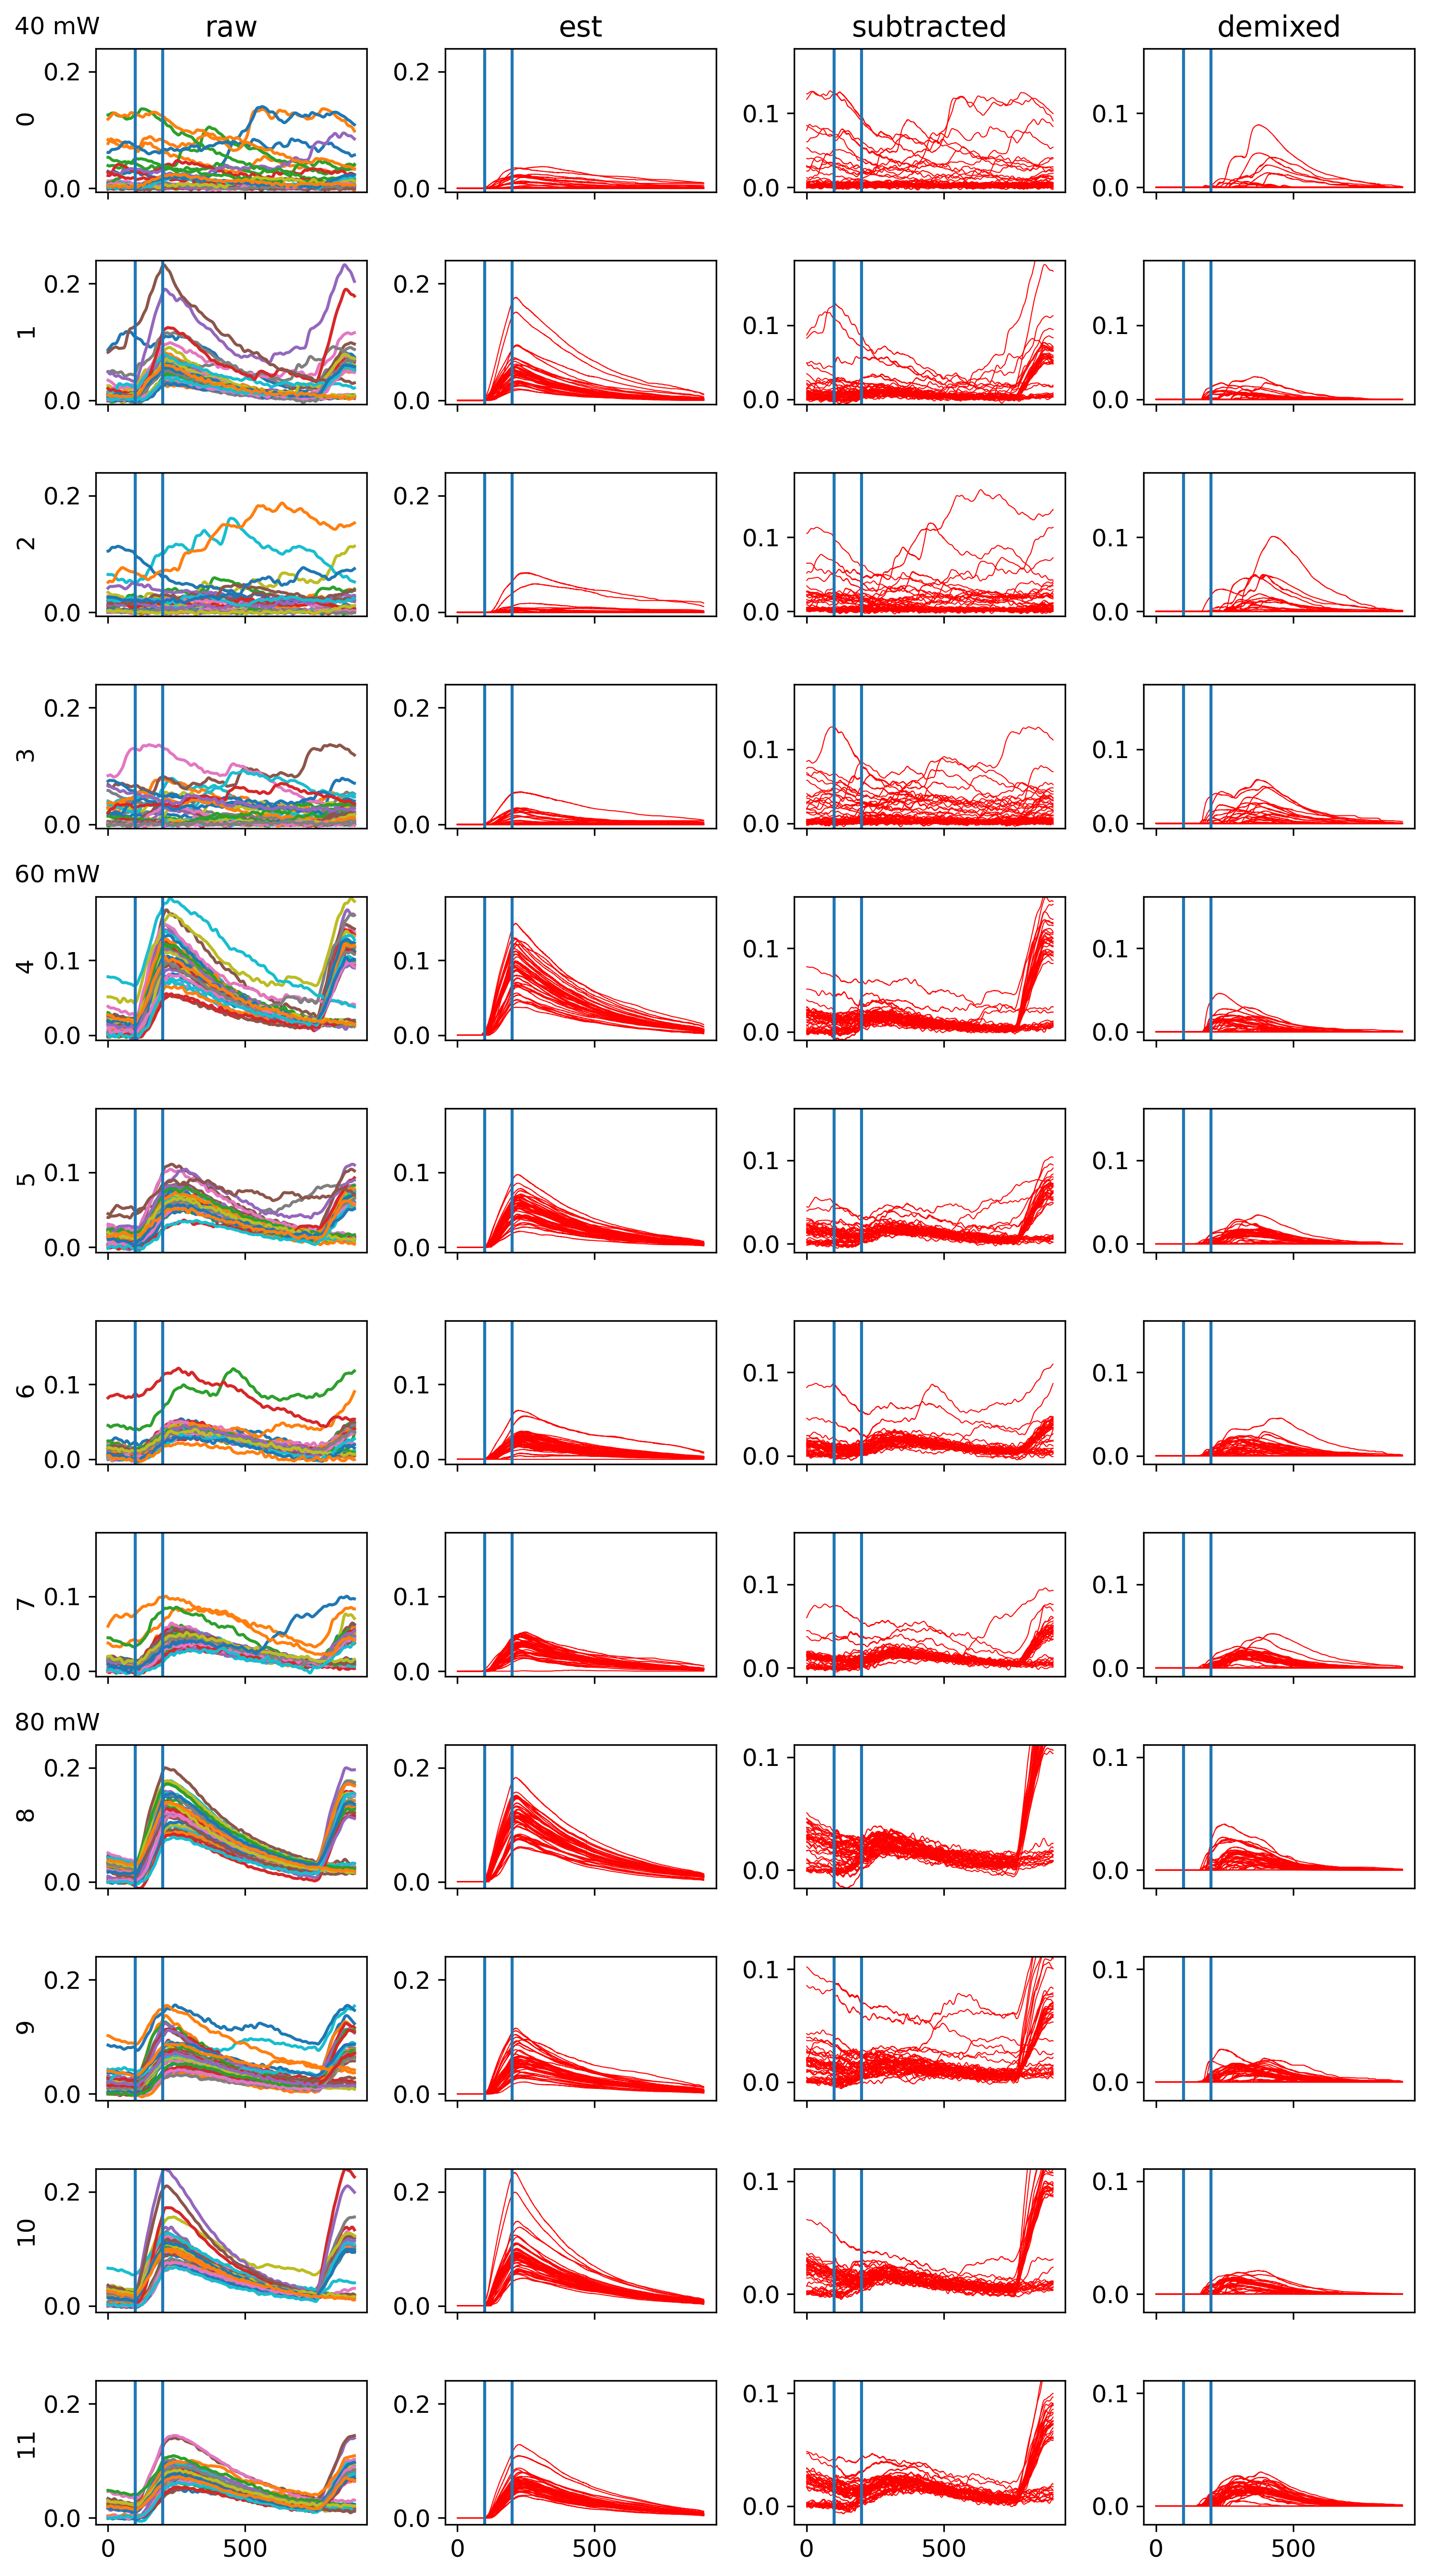

: 

In [50]:
subtract_utils.plot_subtraction_comparison(
    results['raw_tensor'],
    [results['est_tensor']], # est
    [results['subtracted_tensor'],], # subtracted
    [results['demixed_tensor'],], # demixed
    np.unique(powers),
    sort_by='subtracted',
    num_plots_per_power=4,
)